## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## model libraries

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from os.path import splitext
from IPython.display import HTML
%matplotlib inline

## Model variables

In [4]:
# Camera calibration Matrix
nx=9    # number of checker internal corners along x
ny=6    # number of checker internal corners along y
cam_cal_img_name="camera_cal/cal*.jpg"
test_image_filename="camera_cal/test_image.jpg"
img_size = cv2.imread(test_image_filename).shape[:2]
trans_data_file_name ="camera_cal/wide_dist_pickle.p"
sce_video_file_name="challenge_video.mp4"#"project_video.mp4"
rect_video_file_name = "challenge_video_undistorted.mp4"#'project_video_undistorted.mp4'
thd_video_file_name="challenge_video_thresholded.mp4"#'project_video_thresholded.mp4'
test_images_names="test_images/*.jpg"

## Model usefull functions

In [5]:
def display_image(img):
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Camera calibration

In [6]:
def camera_calibration():
    '''
    this function creates and stores tha calbration data
    '''
    print('Camera calibration')
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(cam_cal_img_name)
    
    # Step through the list and search for chessboard corners
    print('getting the points on check board')
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # display a sample image
            if idx==5:
                print('corners on image ',idx)
                display_image(img)
    print ('compute camera parameters')
    # Compute camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( trans_data_file_name, "wb" ))
    
    print('calibration done')
    return None

Camera calibration
getting the points on check board
corners on image  5


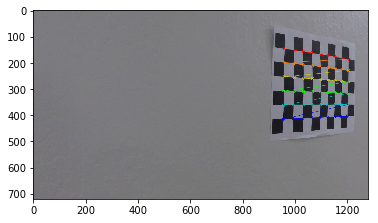

compute camera parameters
calibration done


In [7]:
camera_calibration()

### Run calibration on a sample

In [8]:
def read_calibration_data():
    '''    This function reads the calibration data    '''
    print('Reading camera calibration data')
    dist_pickle = pickle.load( open(trans_data_file_name, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx,dist

In [9]:
def plot_sidebyside(image1,image2,title1,title2):
    image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=40)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

Reading camera calibration data


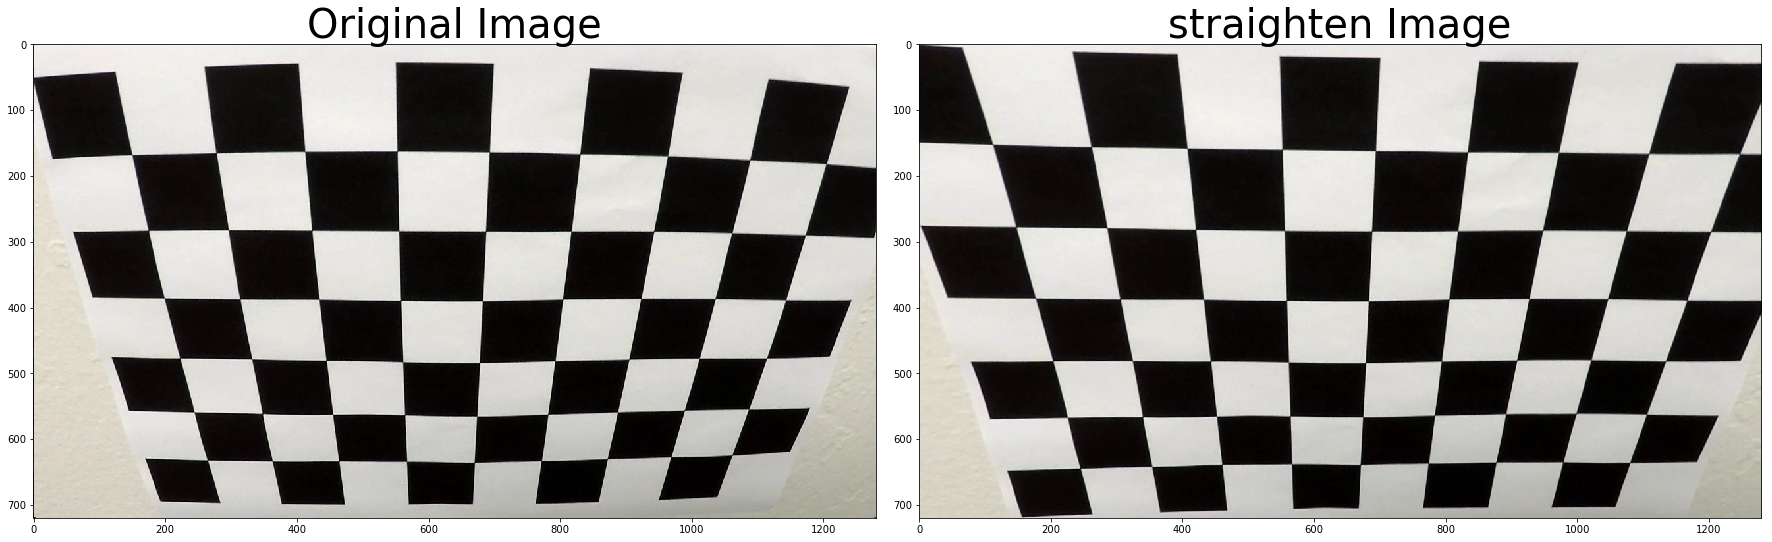

In [10]:
test_image_path="camera_cal/test_image.jpg"

mtx,dist=read_calibration_data()
img1 = cv2.imread(test_image_path)
img2 = cv2.undistort(img1, mtx, dist, None, mtx)

plot_sidebyside(img1,img2,'Original Image','straighten Image')

## Apply a distortion correction to raw images.

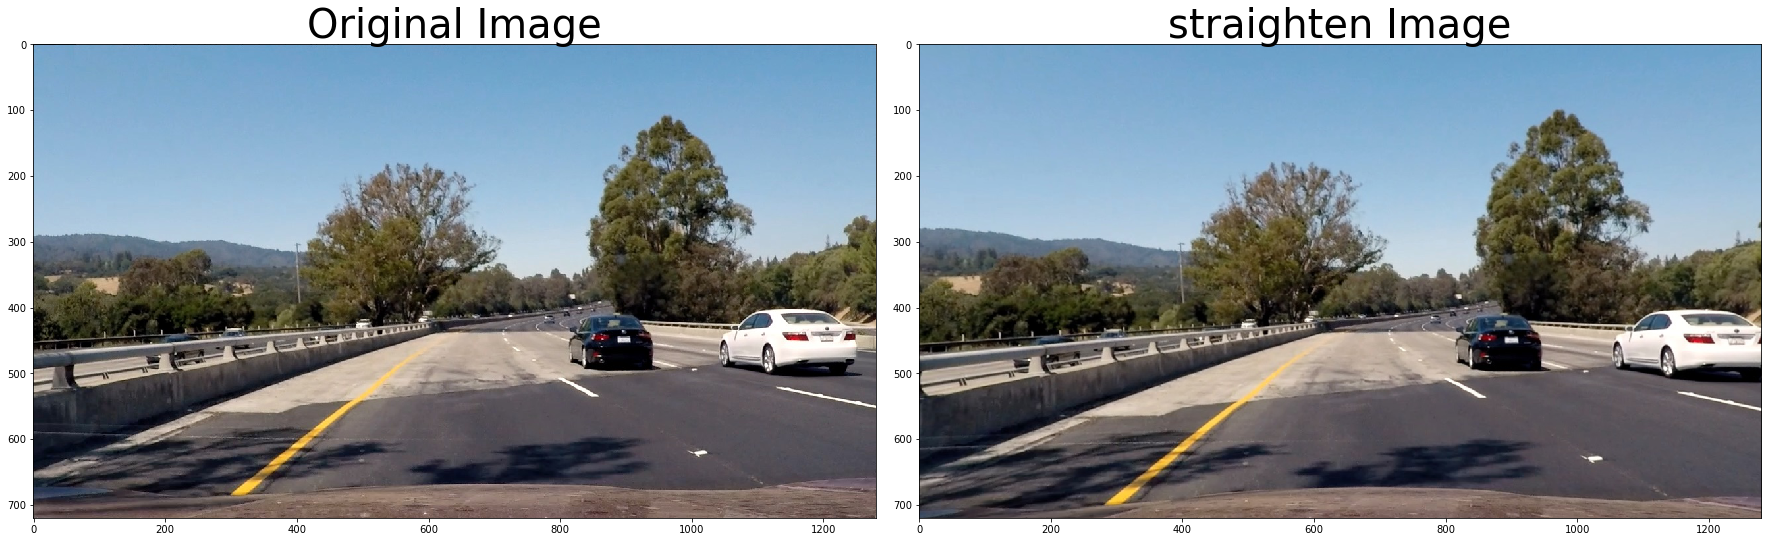

In [11]:
test_image_path="test_images/test4.jpg"

img1 = cv2.imread(test_image_path)
img2 = cv2.undistort(img1, mtx, dist, None, mtx)

plot_sidebyside(img1,img2,'Original Image','straighten Image')

## Apply thresholding and color changes

In [12]:
def mask_image(img):
    img = img.copy()
    
    # Apply a mask on HLS colour channels
    # This selects pixels with higher than 100 saturation and lower than 100 hue
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = np.zeros_like(hsv[:, :, 0])
    yellow_mask[(hsv[:, :, 2] > 210) & (hsv[:, :, 1] >60)] = 1
    white_mask = np.zeros_like(hsv[:, :, 0])
    white_mask[(hsv[:, :, 2] > 210) & (hsv[:, :, 1] <32)] = 1
    mask=np.maximum(white_mask, yellow_mask)
    '''
    # Apply a sobel magnitude threshold
    # I apply a more lenient mag_thresh to the upper part of the transformed image, as this part is blurrier
    # and will therefore have smoother gradients.
    # On the bottom half, this selects pixels with >10 sobel magnitude, and on the top half, 
    # selects pixels with >35 sobel magnitude
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    upper_mag = mag_thresh(img, 3, (10, 255))
    lower_mag = mag_thresh(img, 3, (35, 255))
    
    mag_mask = np.zeros_like(lower_mag)
    mag_mask[:int(mag_mask.shape[0]/2), :] = upper_mag[:int(mag_mask.shape[0]/2), :]
    mag_mask[int(mag_mask.shape[0]/2):, :] = lower_mag[int(mag_mask.shape[0]/2):, :]
    
    # Use the bitwise OR mask of both masks for the final mask
    final_mask = np.maximum(mag_mask, white_mask, yellow_mask)
    '''
    # Return the transformed mask
    return mask

In [13]:
# Tresholding parameters ***********************************to remove****************
ksize = 3               # Choose a larger odd number to smooth gradient measurements
s_thresh=(170, 255)     # sobel magnitude threshold
sx_thresh=(20, 100)     # sobel x filter threshold
#sy_thresh=(20, 100)     # sobel x filter threshold
#dir_tresh= (0.7,1.3)    # direction filter threshold

In [14]:
def test_image_folder():
    '''
    test all the images within a folder with thresholding
    '''
    images = glob.glob(test_images_names)
    #print(images)
    for idx, fname in enumerate(images):
        #image_dst_filename=splitext(fname)[0]+'_try.jpg'
        image_sce=cv2.imread(fname)
        image_binary=mask_image(image_sce)
        #treatment_pipeline(image_sce)
        plt.imshow(image_binary, cmap='gray')
        #cv2.imwrite(image_dst_filename,image_binary)
        #print(image_sce.shape)
        plt.show()
    return None

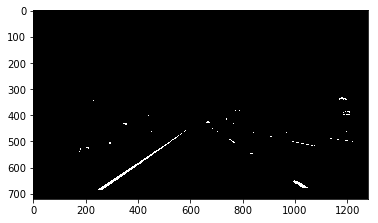

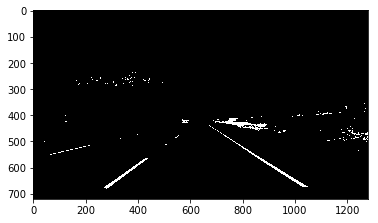

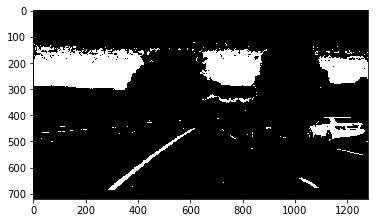

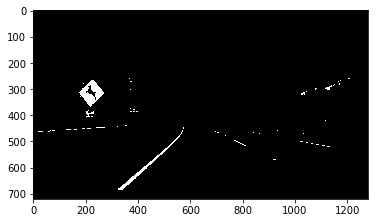

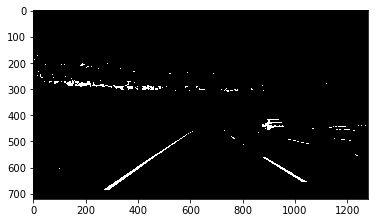

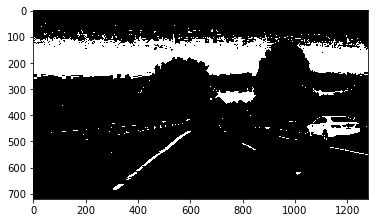

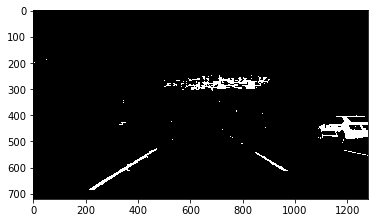

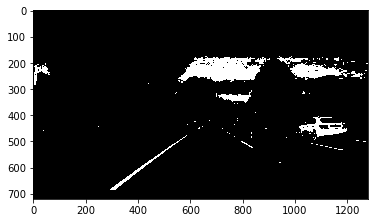

In [15]:
test_image_folder()

## Apply a perspective transform to rectify binary image ("birds-eye view").

### Definition of a starting polygone

In [16]:
poly_color=(200,200,0)
def paint_poly(img,pts_image):
    cv2.fillPoly(img,np.int_([pts_image]), poly_color)
    return img

to compute the transformation, I have assumed the following:
- road doted lines of 1.5m and distance of 3m between lines => ~13m length in total along x
- distance between right and left lines ~ 3.7m
- to simplify, I assume a ratio of 1cm per pixel on the top view

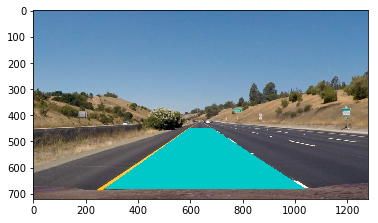

In [17]:
pts_image = np.float32([[(275,680),(597,450),(683,450),(1040,680)]])
pts_road = np.float32([[(300,1300),(300,0),(670,0),(670,1300)]])
img=cv2.imread("test_images/straight_lines1.jpg")
poly_image=paint_poly(img,pts_image)
#print(poly_image.shape)
poly_image=cv2.cvtColor(poly_image,cv2.COLOR_BGR2RGB)
plt.imshow(poly_image)
plt.show()

### Image warping

In [18]:
def warp(img,pts_image, pts_road):
    M = cv2.getPerspectiveTransform(pts_image, pts_road)
    warped = cv2.warpPerspective(img, M, (970,1300), flags=cv2.INTER_LINEAR)
    return warped
def unwarp(img,pts_image, pts_road):
    M = cv2.getPerspectiveTransform(pts_road,pts_image)
    unwarped = cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)
    return unwarped      

Reading camera calibration data


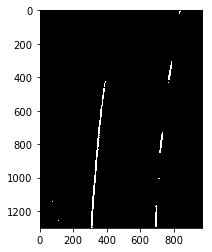

In [19]:
#image_filename="test_images/straight_lines1.jpg"
image_filename="test_images/test3.jpg"
mtx,dist = read_calibration_data()
img1 = cv2.imread(image_filename)
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img3 = cv2.undistort(img2, mtx, dist, None, mtx)
img4 = mask_image(img3)
img5 = warp(img4,pts_image, pts_road)
# display
plt.imshow(img5, cmap='gray')
plt.show()

## Detect lane pixels and fit to find the lane boundary.

In [20]:
def histogram(img):
    histogram = np.sum(img[img.shape[0] / 2:, :], axis=0)
    plt.plot(histogram)
    plt.show()
    return histogram

### Histogram sample

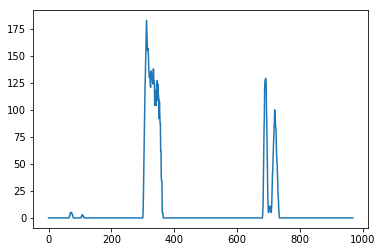

In [21]:
histogram = histogram(img5)

In [22]:
def fitlines(binary_img):
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print("leftx_base",leftx_base, "rightx_base",rightx_base)
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    #if len(leftx) == 0:
    #    left_fit =[]
    #else:
    left_fit = np.polyfit(lefty, leftx, 2)
    
    #if len(rightx) == 0:
    #    right_fit =[]
    #else:
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit,out_img


In [23]:
def plot_lines(binary_img):
    left_fit, right_fit,img_1 = fitlines(binary_img)

    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    plt.imshow(binary_img, cmap='gray')

    plt.subplot(3,1,2)

    plt.imshow(img_1)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 970)
    plt.ylim(1300, 0)

    plt.subplot(3,1,2)
    img2 = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    plt.imshow(img_1)
    result = cv2.addWeighted(img2, .8, img_1, .8, 0)
    plt.imshow(result)

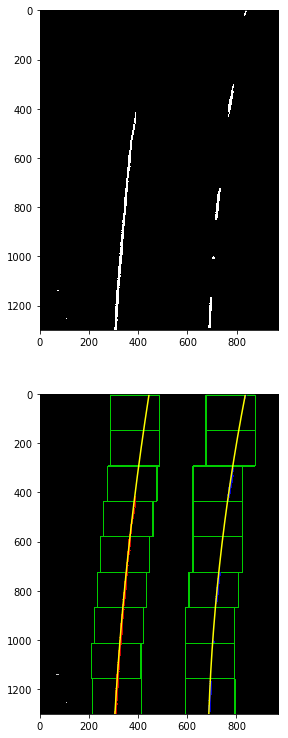

In [24]:
plot_lines(img5)

## Determine the curvature of the lane and vehicle position with respect to center.

In [25]:
def curvature(left_fit, right_fit, binary_img):
    #print(left_fit,right_fit)
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 #13/1300 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 #370 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

In [26]:
left_fit, right_fit,img_1 = fitlines(img5)
left_curverad, right_curverad, center=curvature(left_fit, right_fit, img5)

print(' left line radius of curvarure =',int(left_curverad),'m')
print(' right line radius of curvarure =',int(right_curverad),'m')
print(' average curvature = ',int((left_curverad+left_curverad)/2.),'m')
print(' position from lane center =',int(center*100),'cm')

 left line radius of curvarure = 13741 m
 right line radius of curvarure = 8648 m
 average curvature =  13741 m
 position from lane center = -52 cm


### Warp the detected lane boundaries back onto the original image.

In [27]:
def drawLine(start_img, warped_img,left_fit, right_fit, pts_image, pts_road):
    # Create a black image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    length = warped_img.shape[0]
    ploty = np.linspace(0, length-1, num = length )
    
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped black image
    cv2.fillPoly(color_warp, np.int_([pts]), poly_color)
    #display_image(color_warp)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # note: order of the sce and dst points inverted to reverse transformation
    unwarped = unwarp(color_warp,pts_image,pts_road) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(start_img, 1, unwarped, 0.2, 0)
    return result

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

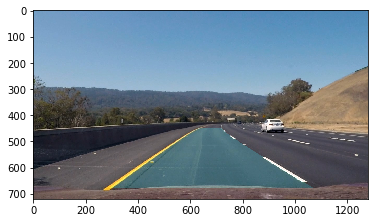

In [28]:
img1 = cv2.imread(image_filename)
img6 = drawLine(img1, img5, left_fit, right_fit, pts_image, pts_road)
display_image(img6)

In [29]:
def display_text(img,left_curverad,right_curverad,center):
    fontScale=1
    thickness=3
    font = cv2.FONT_HERSHEY_SIMPLEX

    if (left_curverad+right_curverad)/20>5000:
        TextM ="~straight"
    else:
        TextM =str(int((left_curverad+right_curverad)/20))+'m'
    TextC=str(int(center*100))+' cm'
    img=cv2.putText(img,'%s' %TextM, (550,40), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)                
    img=cv2.putText(img,'%s' %TextC, (550,700), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    return(img)

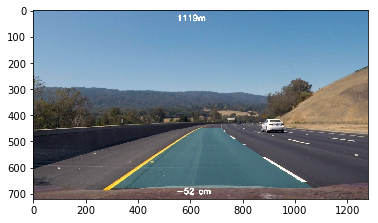

In [30]:
img7=display_text(img6,left_curverad,right_curverad,center)
display_image(img7)

### Process the video

In [31]:
def smooth(l_fit, r_fit, old_l_fit=[0,0,0], old_r_fit=[0,0,0],count=[0]):
    ''' function limit the variation of the fitting polynomial parameters to 20% of the previous value
    note: use of the mutating variables'''
    if count[0]!=0 :
        for i in range(3):
            old_l_fit[i] = 0.2 * l_fit[i] + 0.8 * old_l_fit[i]
            old_r_fit[i] = 0.2 * r_fit[i] + 0.8 * old_r_fit[i]
        count[0] += 1
        return old_l_fit,old_r_fit
    else :
        count[0] += 1
        for i in range(3):
            old_l_fit[i] = l_fit[i]
            old_r_fit[i] = r_fit[i]
        return l_fit, r_fit

def process_the_image(img1):
    img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    img3 = cv2.undistort(img2, mtx, dist, None, mtx)
    img4 = mask_image(img3)
    img5 = warp(img4, pts_image, pts_road)
    left_fit, right_fit,img_1 = fitlines(img5)
    left_fit, right_fit = smooth(left_fit, right_fit)
    left_curverad, right_curverad, center=curvature(left_fit, right_fit, img5)
    img6 = drawLine(img1, img5, left_fit, right_fit, pts_image, pts_road)
    img7=display_text(img6,left_curverad,right_curverad,center)
    return img7 

In [32]:
#output = 'challenge_video_result.mp4'
output = 'project_video_result3.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(process_the_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result3.mp4
[MoviePy] Writing video project_video_result3.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:51<00:00, 11.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result3.mp4 

Wall time: 1min 51s


In [33]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))